# 针对Stable Diffusion-XL的prompt优化

* Stable Diffusion-XL(以下简称“SD-XL”)是当下最常用的文生图扩散模型。本文将介绍如何利用prompt优化Stable Diffusion-XL的生成效果。
* 本篇Cookbook分为两个部分：
  * 第一部分通过两个常见的prompt场景案例，带您快速上手我们的优化方法。
  * 第二部分通过基于中文应用场景的测试，验证了我们的优化方法的可行性和有效性。

## 安装&导入依赖库

首先，安装评估部分所需要的所有包

In [34]:
!pip install -r requirement.txt

引入我们需要的所有包，加载Pickscore的模型：

In [42]:
import os,io,qianfan,torch,statistics
import ae_score
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
from glob import glob
from qianfan.common import Prompt
from qianfan import Text2Image,Completion
from tools import prompt_update
from tools import t2i
from tools import generate_and_save
from transformers import AutoProcessor, AutoModel
from matplotlib.ticker import MaxNLocator


# 定义文件路径
infer_py_path = 'Pickscore-main/infer.py'
raw_folder = 'raw'
update_folder = 'update'
# 将 infer.py 作为模块导入
import sys
sys.path.append(os.path.dirname(infer_py_path))
from infer import calc_probs

在此处输入您的鉴权信息

In [35]:
#初始化百度智能云的IAM ak, sk用于bos和千帆平台的鉴权
os.environ['QIANFAN_ACCESS_KEY'] = 'your_access_key'
os.environ['QIANFAN_SECRET_KEY'] = 'your_secret_key'

## 案例一：针对中文特异词汇的优化--夫妻肺片
* 夫妻肺片是一道经典的中国小吃，但是对于Stable-Diffusion来说可能是一种动物的器官，我们的prompt优化可以避免这样的错误。
* 这里以“夫妻肺片”为例，来展示我们的prompt优化针对中文歧义词的效果。

首先我们先创建一个简单的任务描述prompt:

In [4]:
pt = "夫妻肺片"
#将文本转为LLM的prompt格式
p = Prompt(pt)

使用优化前的prompt测试效果

In [5]:
#加载SD-XL并展示生成结果
t2i(pt)

可以看到，SD-XL对于输入的prompt产生了误解，仅仅理解了字面意思，生成了器官的图片。
![alt text](img/lung_raw.png)

接下来，将上述prompt进行优化，提升图片的生成效果:

In [6]:
#将输入prompt进行优化
output = prompt_update(pt)


A plate of Spicy Beef Slices with Beef Offal, drenched in chili oil, loaded with cilantro and peanuts, intricate textures, realistic texture details, bright colors, food photography, high contrast lighting, vibrant colors, appetizing, photorealistic, (detailed texture:1.3), high resolution, 8k, HDR, natural lighting

Negative prompt: text, logos, watermarks, out of frame, blurred, low contrast, messy, artificial lighting, discolored.


以下为优化prompt的生成效果展示：

In [7]:
#加载SD-XL并展示生成结果
t2i(output)

在优化了prompt后，生成的图片解决了中英文的语言歧义，符合prompt的原意，而且提升了展示力。

![alt text](img/lung_update.png)

## 案例二：针对简单提示词的扩写优化--一只高贵的柯基犬
* 还有一类prompt，它们在理解上并没有歧义，但是包含的细节极少，无法给到足够的提示，可能会导致生成效果不佳。
* 这里我们以"一只高贵的柯基犬"的任务为例，来展示我们的prompt优化针对扩展提示词的效果。

首先我们先创建一个简单的任务描述prompt:

In [32]:
pt = "一只高贵的柯基犬"
#将文本转为LLM的prompt格式
p = Prompt(pt)

使用优化前的prompt测试效果

In [10]:
#加载SD-XL并展示生成结果
t2i(pt)

生成的图片大体符合提示词，但是细节缺失较多，整体画面不够生动。

![alt text](img/dog_raw.png)



接下来，将上述prompt进行优化，提升图片的生成效果:

In [33]:
#将输入prompt进行优化
output = prompt_update(pt)

a regal Corgi, wearing a fancy collar and bowtie, elegant pose, soft fur, photorealistic, vibrant colors, detailed landscape, studio lighting, highly detailed, realistic shadows, HDR, (detailed fur:1.3), 8k

Negative prompt: text, logos, watermarks, out of frame, messy, blurry, mutated, deformed features, cartoon




以下为优化prompt的生成效果展示：

In [13]:
t2i(output)

图片的画面整体提升很大，将柯基犬的主体描绘得更加细致，整体构图更加协调，表现力更强。

![alt text](img/dog_update.png)

## 验证

* 为体现本方案的优化能力，在此使用了Pick Score和Aesthetics Score作为评价指标，以此验证可行性。
* Pick Score: 衡量了初始的输入prompt和优化后的图片之间的关联度。用此指标来体现我们的优化没有偏出用户的主观意图。
* Aesthetics Score: 衡量了优化后的图片的美观度。用此指标来衡量优化后的图片是否符合用户的审美需求。



### 测试集准备

根据DiffusionDB的数据集，我们构造了一个简单的中文prompt列表以供测试：

In [35]:
#中文prompt用于生成优化前的图片以及aesthestics score打分
raw_prompt = [
    "黄昏谷仓画", "绿树成荫，花团锦簇","翱翔在山间的凤凰","宫保鸡丁","一个摆满玩具机器人的房间","一座有许多雕像在里面的丛林寺庙","两匹马的黑白照片","一座庞大的宫殿,皇帝坐在正中央,大臣们骑着扫帚在殿内朝拜,有的大臣在汇报工作,整个大殿金碧辉煌","一只可爱的小猫","一座哥特式建筑","一对肝胆相照的兄弟","一只蜗牛",
    "一个挑灯夜读的高中生,他坐在电脑桌前","咖啡色的天空，绿色的湖，蓝色的草地","神圣的金字塔，门口坐着狮身人面像","两只猫鼬在野外和热气球在一起","一幅描绘白裙少女在雏菊田中翩翩起舞的画作","春天来了，万物复苏","火光冲天的未来飞船","一条狗，一只猫，耶稣在中间照顾所有的生物，有人，有植物","蚂蚁上树","夫妻肺片","一只飞过山的凤凰","机器人大战","虫虫危机"
]
#英文prompt用于pickscore打分
raw_prompt_eng = [
    "Twilight Barn Painting", 
    "Shady Green Trees and Blooming Flowers", 
    "The phoenix that soars in the mountains", 
    "Kung Pao Chicken", 
    "A Room Filled with Toy Robots", 
    "A Jungle Temple with Many Statues Inside", 
    "Black and White Photo of Two Horses", 
    "A Grand Palace with the Emperor in the Center, Ministers on Brooms Paying Homage, Some Reporting Work, the Entire Hall Gleaming with Gold", 
    "A Cute Kitten", 
    "A Gothic Building", 
    "Two Brothers with Deep Bonds", 
    "A Snail", 
    "A High School Student Studying Late at Night at a Computer Desk", 
    "Coffee-Colored Sky, Green Lake, Blue Grass", 
    "Sacred Pyramid with a Sphinx at the Entrance", 
    "Two Meerkats in the Wild with a Hot Air Balloon", 
    "A Painting of a Girl in a White Dress Dancing in a Daisy Field", 
    "Spring Arrives, Everything Awakens", 
    "A Futuristic Spaceship with Flames Bursting", 
    "A Dog, a Cat, and Jesus Caring for All Creatures, Including People and Plants", 
    "Stir-Fried Noodles with Minced Pork", 
    "Spicy Sliced Beef and Tripe", 
    "A Phoenix Flying Over a Mountain", 
    "Robot Battle", 
    "A Bug's Life"
]


首先，将优化前的prompt对应图片保存到自定义的文件夹中

In [20]:
#将raw_prompt输入到SD-XL,生成图片并保存到当前目录下的raw文件夹
generate_and_save(raw_prompt, "raw")

Image 0 saved as raw/0.png
Image 1 saved as raw/1.png
Image 2 saved as raw/2.png
Image 3 saved as raw/3.png
Image 4 saved as raw/4.png
Image 5 saved as raw/5.png
Image 6 saved as raw/6.png
Image 7 saved as raw/7.png
Image 8 saved as raw/8.png
Image 9 saved as raw/9.png
Image 10 saved as raw/10.png
Image 11 saved as raw/11.png
Image 12 saved as raw/12.png
Image 13 saved as raw/13.png
Image 14 saved as raw/14.png
Image 15 saved as raw/15.png
Image 16 saved as raw/16.png
Image 17 saved as raw/17.png
Image 18 saved as raw/18.png
Image 19 saved as raw/19.png
Image 20 saved as raw/20.png
Image 21 saved as raw/21.png
Image 22 saved as raw/22.png
Image 23 saved as raw/23.png
Image 24 saved as raw/24.png


将输入的prompt进行批量优化

In [21]:
#定义一个空列表，用于存储优化后的prompt
update_prompt = []
#依次遍历每一条rawdata
for pt in raw_prompt:
    p = prompt_update(pt)
    update_prompt.append(p)
    print(p)

A rustic barn in a serene valley at dusk, golden hour lighting, warm orange and purple hues, silhouette of trees in the distance, soft light streaming through cracks in the wooden walls, intricate details of weathered wood, (rustic atmosphere: 1.5), photorealistic, highly detailed, trending on artstation, realistic landscape, HDR, natural lighting

Negative prompt: text, logos, watermarks, out of frame, modern buildings, unnatural colors, cartoonish, simplified, flat colors, low resolution.
A rustic barn in a serene valley at dusk, golden hour lighting, warm orange and purple hues, silhouette of trees in the distance, soft light streaming through cracks in the wooden walls, intricate details of weathered wood, (rustic atmosphere: 1.5), photorealistic, highly detailed, trending on artstation, realistic landscape, HDR, natural lighting

Negative prompt: text, logos, watermarks, out of frame, modern buildings, unnatural colors, cartoonish, simplified, flat colors, low resolution.
A dense 

In [27]:
#将update_prompt依次输入到SD-XL,生成图片并保存到当前目录下的update文件夹
generate_and_save(update_prompt, "update")

Image 0 saved as update/0.png
Image 1 saved as update/1.png
Image 2 saved as update/2.png
Image 3 saved as update/3.png
Image 4 saved as update/4.png
Image 5 saved as update/5.png
Image 6 saved as update/6.png
Image 7 saved as update/7.png
Image 8 saved as update/8.png
Image 9 saved as update/9.png
Image 10 saved as update/10.png
Image 11 saved as update/11.png
Image 12 saved as update/12.png
Image 13 saved as update/13.png
Image 14 saved as update/14.png
Image 15 saved as update/15.png
Image 16 saved as update/16.png
Image 17 saved as update/17.png
Image 18 saved as update/18.png
Image 19 saved as update/19.png
Image 20 saved as update/20.png
Image 21 saved as update/21.png
Image 22 saved as update/22.png
Image 23 saved as update/23.png
Image 24 saved as update/24.png


### 通过Aesthetics Score评价优化方案的可行性

* Aesthetics Score 是一种衡量图像美学素质的数值指标。
* 该指标的计算方法是将图像的不同视觉特征（如色彩、形状、线条、纹理、光照、透视、空间分布等）的重要程度进行加权，并将加权结果乘以相应的权重，得到的结果即为图像的美学得分。
* 美学得分的范围从 0 到 10，数值越高，图像的视觉效果越好。

首先，将未优化过的初始raw_prompt输入到模型中，得到优化前的分数，作为baseline。

In [8]:
# 构造 args 对象，用于传入/raw下的优化前的图片
args = ae_score.argparse.Namespace(
    image_file_or_dir="raw",# 输入图像文件或文件夹路径
    save_csv=False,
    model=ae_score.MODEL,
    device=None
)
# 运行 main 函数
raw_scores = ae_score.main(args)
# 保存所有分数列表和分数期望
raw_score = raw_scores[0]
all_raws = []
for lst in raw_scores[1]:
    all_raws.append(lst['score'])

Loading sac+logos+ava1-l14-linearMSE
Loading CLIP ViT-L/14


100%|██████████| 25/25 [00:10<00:00,  2.30it/s]

16.png 6.841940402984619
7.png 6.745919227600098
13.png 6.737991809844971
2.png 6.645719528198242
5.png 6.6044769287109375
18.png 6.601787090301514
12.png 6.52354621887207
15.png 6.317983627319336
1.png 6.285238265991211
22.png 6.2014336585998535
0.png 6.191251277923584
19.png 6.138124465942383
14.png 6.092841625213623
10.png 6.074313640594482
23.png 6.055541515350342
9.png 5.978781223297119
8.png 5.959288597106934
3.png 5.864199638366699
4.png 5.828464984893799
21.png 5.726274490356445
17.png 5.555602073669434
11.png 5.473254203796387
20.png 5.4281768798828125
24.png 5.410065650939941
6.png 5.213546276092529
average score: 6.099830532073975
mean: 6.099830532073975 all: [6.841940402984619, 6.745919227600098, 6.737991809844971, 6.645719528198242, 6.6044769287109375, 6.601787090301514, 6.52354621887207, 6.317983627319336, 6.285238265991211, 6.2014336585998535, 6.191251277923584, 6.138124465942383, 6.092841625213623, 6.074313640594482, 6.055541515350342, 5.978781223297119, 5.9592885971069

接下来，对已优化的prompt生成的图片进行评测：

In [11]:
# 构造 args 对象，用于传入/update下的优化后的图片
args = ae_score.argparse.Namespace(
    image_file_or_dir="update",# 输入图像文件或文件夹路径
    save_csv=False,
    model=ae_score.MODEL,
    device=None
)
# 运行 main 函数
update_scores = ae_score.main(args)
# 保存所有分数列表和分数期望
update_score = update_scores[0]
all_updates = []
for lst in update_scores[1]:
    all_updates.append(lst['score'])

Loading sac+logos+ava1-l14-linearMSE
Loading CLIP ViT-L/14


100%|██████████| 25/25 [00:11<00:00,  2.18it/s]

1.png 7.056516647338867
12.png 7.022249221801758
7.png 6.984950065612793
19.png 6.964156150817871
17.png 6.926566123962402
0.png 6.855005264282227
16.png 6.853736877441406
10.png 6.825506210327148
13.png 6.798949718475342
22.png 6.68180513381958
5.png 6.6625871658325195
14.png 6.540289878845215
4.png 6.3354339599609375
20.png 6.323609352111816
2.png 6.278228759765625
8.png 6.273447036743164
11.png 6.2193193435668945
23.png 6.215234756469727
3.png 6.162156105041504
6.png 6.09523868560791
18.png 6.039311408996582
9.png 6.030139923095703
15.png 6.010545253753662
21.png 5.9157257080078125
24.png 5.8753461837768555
average score: 6.477842197418213


* 在总量为25的数据集上进行了Aesthetics score美学评分，最终我们的图片美化效果提升幅度接近6%。
* 从raw_prompt和update_prompt的aesthetics score分数对比图可以明显看到，针对每一条prompt的优化均有分数上的提升，且最大提升幅度达到了近13%。

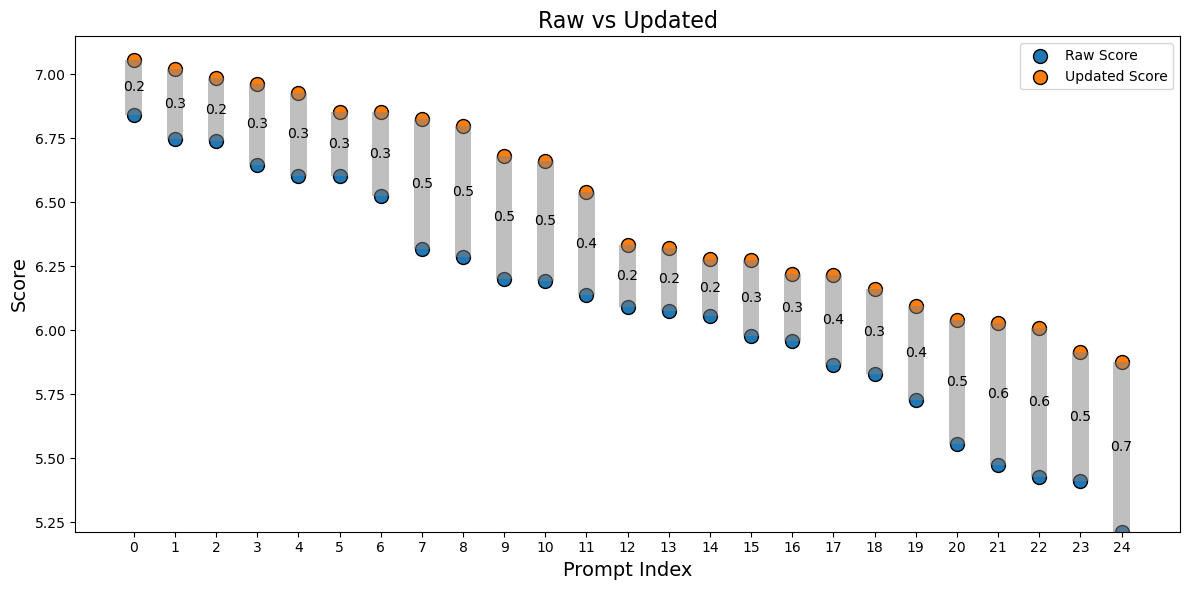

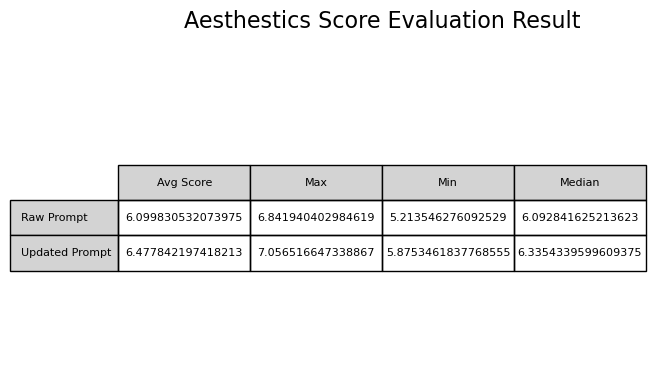

In [64]:
raws = np.array(all_raws)
updates = np.array(all_updates)

# 计算最大值、最小值和中位数
max_raw = np.max(raws)
min_raw = np.min(raws)
median_raw = np.median(raws)

max_update = np.max(updates)
min_update = np.min(updates)
median_update = np.median(updates)

raw_scores = all_raws
update_scores = all_updates

# 计算差值
diff_scores = np.array(update_scores) - np.array(raw_scores)

# 绘制图表
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制原始分数和更新后的分数
ax.scatter(range(len(raw_scores)), raw_scores, marker='o', s=100, color='tab:blue', label='Raw Score', edgecolor='black', linewidth=1)
ax.scatter(range(len(update_scores)), update_scores, marker='o', s=100, color='tab:orange', label='Updated Score', edgecolor='black', linewidth=1)

# 添加柱子
for i in range(len(raw_prompt)):
    height = update_scores[i] - raw_scores[i]
    ax.bar(i, height, bottom=raw_scores[i], color='gray', alpha=0.5, width=0.4)
    # 在柱子中间显示具体差值
    ax.text(i, raw_scores[i] + height/2, f'{height:.1f}', ha='center', va='center', color='black', fontsize=10)

# 设置图表标题和轴标签
ax.set_title('Raw vs Updated', fontsize=16)
ax.set_xlabel('Prompt Index', fontsize=14)
ax.set_ylabel('Score', fontsize=14)

# 设置X轴刻度标签为序号
ax.set_xticks(range(len(raw_prompt)))

# 添加图例
ax.legend()

plt.tight_layout()
plt.show()

# 创建一个 3x3 的表格
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')  # 隐藏坐标轴

# 设置表格的行列数
rows = 2
cols = 4

# 创建数据
data = [[raw_score, max_raw, min_raw,median_raw]   ,
        [update_score, max_update, min_update,median_update]]

# 创建表头
row_labels = ['Raw Prompt', 'Updated Prompt']
col_labels = ['Avg Score', 'Max', 'Min','Median']

# 绘制表格
the_table = ax.table(cellText=data,
                     rowLabels=row_labels,
                     colLabels=col_labels,
                     loc='center',
                     cellLoc='center',
                     rowColours=['lightgray'] * rows,  # 设置行颜色
                     colColours=['lightgray'] * cols,  # 设置列颜色
                     cellColours=[['none'] * cols] * rows)  # 设置单元格颜色

# 添加表格标题
ax.set_title('Aesthestics Score Evaluation Result', fontsize=16, pad=20)

# 调整表格大小
the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
the_table.scale(1.5, 2)  # 调整表格大小

# 显示图像
plt.tight_layout()
plt.show()

### 通过Pick Score评价优化方案的有效性
* Pick score用于评价图像和提示词的相似度，保证生成图片的有效性
* 该指标的计算方法是通过对输入提示词的长度、词频、主题相关性和生成效果的综合评估，得出提示词的有效性评分。
* Pick Score的得分经过了softmax处理，区间在0-1之间，数值越大，关联程度越高。
* 原论文链接：https://arxiv.org/abs/2305.01569
* 由于Pick Score模型限制，此处使用的prompt为英文原版prompt。

In [26]:
# 加载模型和处理器
device = "cpu"
processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"

processor = AutoProcessor.from_pretrained(processor_name_or_path)
model = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)

# 获取原始图像文件路径
raw_image_paths = sorted(glob(os.path.join(raw_folder, '*.png')))
update_image_paths = sorted(glob(os.path.join(update_folder, '*.png')))

pickscore_results = []
# 循环计算每个 prompt 的概率
for i, prompt in enumerate(raw_prompt_eng):
    #raw_image_path = raw_image_paths[i]
    image = [Image.open(raw_image_paths[i]),Image.open(update_image_paths[i])]
    probs = calc_probs(prompt, image)
    pickscore_results.append(probs)
    print(f'Prompt: {prompt}, Probabilities: {probs}')

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Prompt: Twilight Barn Painting, Probabilities: [0.39845356345176697, 0.6015465259552002]
Prompt: Shady Green Trees and Blooming Flowers, Probabilities: [0.2977561950683594, 0.7022437453269958]
Prompt: A Noble Corgi, Probabilities: [0.16145963966846466, 0.8385403752326965]
Prompt: Kung Pao Chicken, Probabilities: [0.2974173426628113, 0.7025826573371887]
Prompt: A Room Filled with Toy Robots, Probabilities: [0.32238972187042236, 0.6776102781295776]
Prompt: A Jungle Temple with Many Statues Inside, Probabilities: [0.3444701135158539, 0.655529797077179]
Prompt: Black and White Photo of Two Horses, Probabilities: [0.783403217792511, 0.21659676730632782]
Prompt: A Grand Palace with the Emperor in the Center, Ministers on Brooms Paying Homage, Some Reporting Work, the Entire Hall Gleaming with Gold, Probabilities: [0.4876033365726471, 0.5123966336250305]
Prompt: A Cute Kitten, Probabilities: [0.5886120200157166, 0.41138795018196106]
Prompt: A Gothic Building, Probabilities: [0.471862941980361

* 从上面的分数可以看到，还是有一些prompt在优化后反而在Pick Score上的评分低于原始prompt的评分，这是因为Pick Score模型本身存在一些局限性。下面我们挑出一个最大负例进行分析：
* 在输入prompt为“两匹马的黑白照片”这一组图片中，优化前的分数为0.78，优化后的仅有0.22。如下图所示，左边对应原始prompt的生成图片，右边对应优化prompt的生成图片：
    * 可以明显看出，左边的图片实际上有很大一部分是无法识别的内容，而右边的显然看上去更加清晰，也更符合用户的预期。因此，模型本身的局限性是会导致对于图片评估的误判的。｜


<div style="display: flex; align-items: center; gap: 20px;">
    <img src="img/horse_raw.png" alt="Raw Image" style="width: 50%;"/>
    <img src="img/horse_update.png" alt="Updated Image" style="width: 50%;"/>
</div>


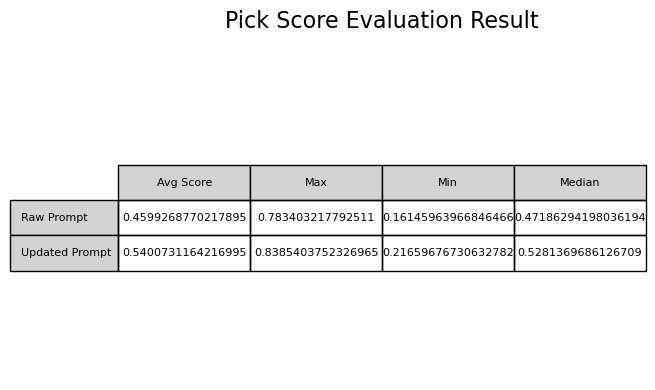

In [63]:
import statistics

results = pickscore_results  # 计算优化有效的结果数量
#effective_count = sum(1 for result in results if result[1] > result[0])
# 计算优化程度的平均值和中位数
improvement_scores = [result[1] - result[0] for result in results if result[1] > result[0]]
avg_improvement = statistics.mean(improvement_scores)
median_improvement = statistics.median(improvement_scores)
standeard_deviation = statistics.stdev(improvement_scores)

# 计算优化前的均值
before_mean = statistics.mean([result[0] for result in results])
# 计算优化后的均值
after_mean = statistics.mean([result[1] for result in results])
before_median = statistics.median([result[0] for result in results])
after_median = statistics.median([result[1] for result in results])
before_max = max([result[0] for result in results])
after_max = max([result[1] for result in results])
before_min = min([result[0] for result in results])
after_min = min([result[1] for result in results])
# print(f"优化前的均值: {before_mean}")
# print(f"优化后的均值: {after_mean}")
# print(f"优化程度的平均值: {avg_improvement}")
# print(f"优化程度的中位数: {median_improvement}")
# print(f"优化程度的标准差: {standeard_deviation}")
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')  # 隐藏坐标轴

# 设置表格的行列数
rows = 2
cols = 4

# 创建数据
data = [[before_mean, before_max, before_min, before_median]   ,
        [after_mean, after_max, after_min, after_median]]

# 创建表头
row_labels = ['Raw Prompt', 'Updated Prompt']
col_labels = ['Avg Score', 'Max', 'Min','Median']

# 绘制表格
the_table = ax.table(cellText=data,
                     rowLabels=row_labels,
                     colLabels=col_labels,
                     loc='center',
                     cellLoc='center',
                     rowColours=['lightgray'] * rows,  # 设置行颜色
                     colColours=['lightgray'] * cols,  # 设置列颜色
                     cellColours=[['none'] * cols] * rows)  # 设置单元格颜色

# 添加表格标题
ax.set_title('Pick Score Evaluation Result', fontsize=16, pad=20)

# 调整表格大小
the_table.auto_set_font_size(False)
the_table.set_fontsize(8)
the_table.scale(1.5, 2)  # 调整表格大小

# 显示图像
plt.tight_layout()
plt.show()

## 总结
* 在Aesthestics Score和Pick Score两个测试模型中，我们的方法均有出色的表现。这表明，轻量化的优化方法也可以有效地提升prompt的质量。